# Machine learning on microcontrollers project by Hugo Fontaine

## Project description :
The goal is use the MAX78000FTHR board and its camera to do face recognition. For that we construct and train a model on the WIDER FACE dataset using Pytorch.

In [1]:
#Requirements :
#matplotlib
#numpy
#pythorch
#os
#gdown
#python 3.11.8

In [2]:
#imports
import random as rd
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#CONSTANTS
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480

### 1 -Load the dataset

In [ ]:
from torchvision.datasets import WIDERFace
from torchvision import transforms
import torch.nn.functional as F
import torch

#get current directory
cwd = os.getcwd()
#get path to dataset directory
dataset_path = os.path.join(cwd, 'dataset')

class WiderDataset(WIDERFace):
    def __init__(self, root, split, height, width, transform=None, target_transform=None, download=True):
        super(WiderDataset, self).__init__(root, split, None, None, download)
        self.height = height
        self.width = width
        if(transform != None or target_transform != None):
            print("Warning: transform and target_transform are not supported and will be ignored")
    
    def __getitem__(self, index):
        image, target = super(WiderDataset, self).__getitem__(index)
        image = transforms.ToTensor()(image)
        H, W = image.shape[1:]
        crop_x = int((W-self.width)/2); crop_y = int((H-self.height)/2)
        if H < self.height or W < self.width :
            pad_h = max(0, self.height-H)
            pad_w = max(0, self.width-W)
            pad_h1 = pad_h//2; pad_h2 = pad_h-pad_h1
            pad_w1 = pad_w//2; pad_w2 = pad_w-pad_w1
            image = F.pad(image, (pad_w1, pad_w2, pad_h1, pad_h2), mode='constant', value=0)
            crop_x = 0; crop_y = 0

        image = image[:,crop_y:crop_y+self.height, crop_x:crop_x+self.width]

        #normalize image
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        
        largest_bbox = np.array([0, 0, 0, 0], dtype=np.float32)
        largest_bbox_area = 0
        for i in range(len(target['bbox'])) :
            x, y, w, h = target['bbox'][i]
            x = int(x); y = int(y); w = int(w); h = int(h)
            if x >= crop_x + self.width or y >= crop_y + self.height :
                continue
            if x + w <= crop_x or y + h <= crop_y :
                continue
            x1 = max(crop_x, x); wn = w-(x1-x)
            y1 = max(crop_y, y); hn = h-(y1-y)
            if x1 + wn > crop_x + self.width :
                wn = crop_x + self.width - x1
            if y1 + hn > crop_y + self.height :
                hn = crop_y + self.height - y1
            area = wn*hn
            if area >= largest_bbox_area and area >= 0.4*w*h :
                largest_bbox = np.array([(x1-crop_x) /IMAGE_WIDTH, (y1-crop_y) /IMAGE_HEIGHT, wn /IMAGE_WIDTH, hn/IMAGE_HEIGHT], dtype=np.float32)
                largest_bbox_area = area
        
        res = np.zeros(2, dtype=np.float32)
        res[0] = largest_bbox_area == 0
        res[1] = not(largest_bbox[0])

        return image, (torch.tensor(res), torch.tensor(largest_bbox))

#download WIDER_face dataset with pythorch
dataset_train = WiderDataset(root=dataset_path, split='train', height=IMAGE_HEIGHT, width=IMAGE_WIDTH)
dataset_val = WiderDataset(root=dataset_path, split='train', height=IMAGE_HEIGHT, width=IMAGE_WIDTH)
dataset_test = WiderDataset(root=dataset_path, split='train', height=IMAGE_HEIGHT, width=IMAGE_WIDTH)

#print some information about the dataset
print("Number of training images: ", len(dataset_train))
print("Number of validation images: ", len(dataset_val))
print("Number of test images: ", len(dataset_test))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Number of training images:  12880
Number of validation images:  12880
Number of test images:  12880


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8256302..2.64].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.11191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to 

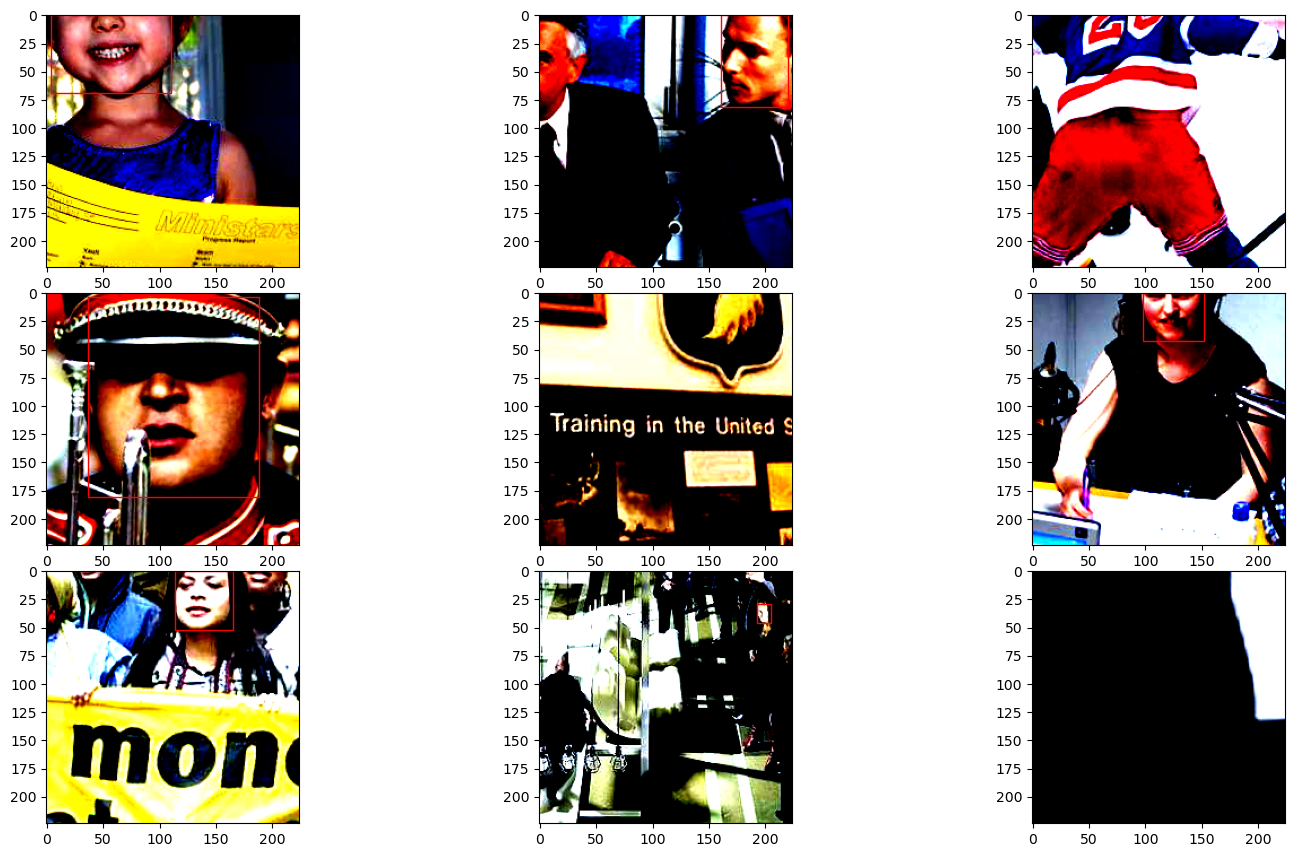

In [246]:
#show some images in figure with ther bbox
fig = plt.figure(figsize=(18.5, 10.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(9):
    image, (res, largest_bbox) = dataset_train[rd.randint(0, len(dataset_train) - 1)]
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image.permute(1, 2, 0))
    x, y, w, h = largest_bbox
    rect = plt.Rectangle((x*IMAGE_WIDTH, y*IMAGE_HEIGHT), w*IMAGE_WIDTH, h*IMAGE_HEIGHT, fill=False, color='red')
    ax.add_patch(rect)

### 2 - Preprocess the dataset

In [247]:
from torch.utils.data import DataLoader

batch_size = 32

#Custom DataLoader
class CustomDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

    def __iter__(self):
        for image, target in super().__iter__():
            yield image, target

load_train = DataLoader(dataset_train, batch_size=batch_size)
load_val = DataLoader(dataset_val, batch_size=batch_size)
load_test = DataLoader(dataset_test, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..1.8208281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data 

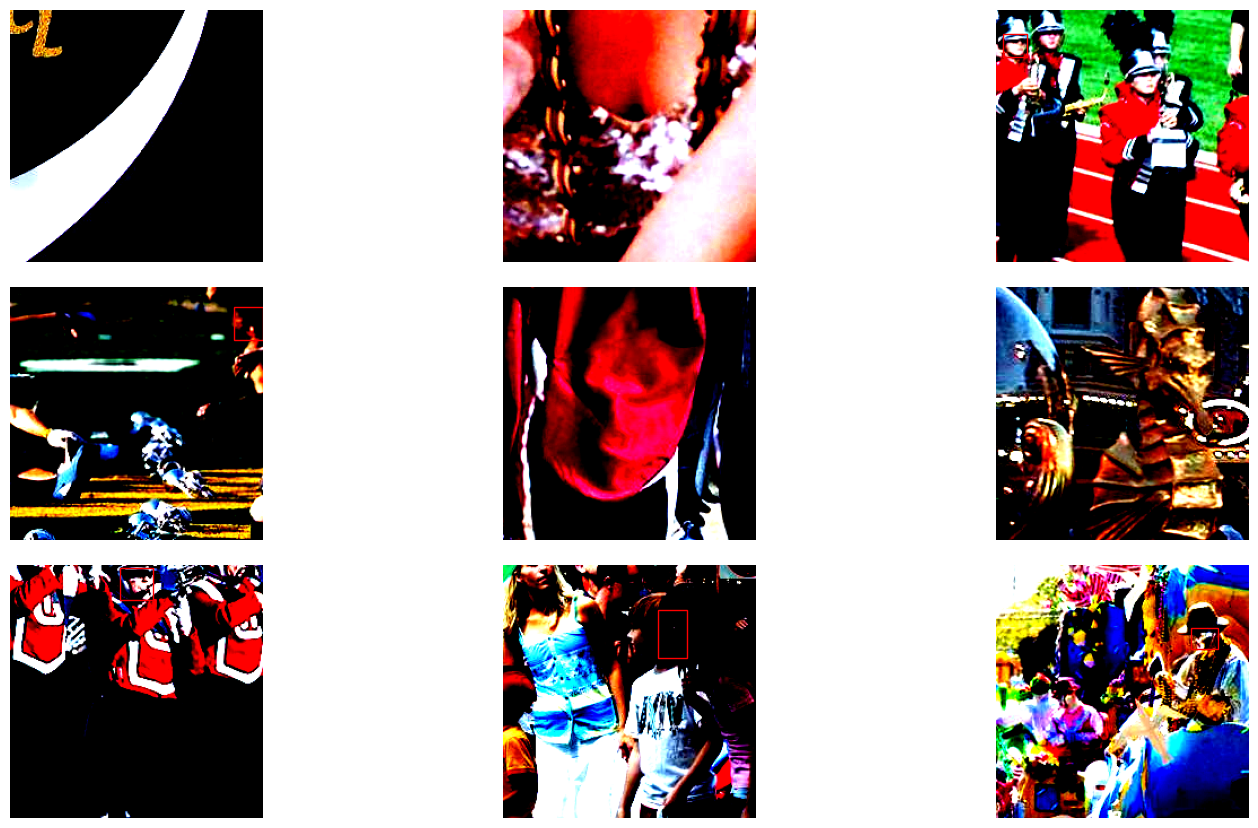

In [248]:
## show some images in figure with ther biggest bbox, given by the CustomDataLoader
fig = plt.figure(figsize=(18.5, 10.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
images, (res, targets) = next(iter(load_train))
for i, (image, largest_bbox) in enumerate(zip(images, targets)):
    if i > 8 :
        break
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image.permute(1, 2, 0))
    im_width, im_height, w, h = largest_bbox
    rect = plt.Rectangle((im_width * IMAGE_WIDTH, im_height * IMAGE_HEIGHT), w*IMAGE_WIDTH, h*IMAGE_HEIGHT, fill=False, color='red')
    ax.add_patch(rect)
    ax.axis('off')

### 3 - Construct the model

In [252]:
import torchvision.models as models
from torchvision.models.mobilenetv3 import MobileNet_V3_Small_Weights
import torch.nn as nn
import torchsummary
mobile_net3 = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

# show model summary
torchsummary.summary(mobile_net3, (3, IMAGE_HEIGHT, IMAGE_WIDTH))

class FaceDetector(nn.Module) :
    def __init__(self, pretrained_model, num_channels = 3, dims = (224, 224)) :
        super(FaceDetector, self).__init__()
        self.pretrained_model = pretrained_model
        # for param in self.pretrained_model.parameters(): # freeze the pretrained model
        #     param.requires_grad = False
        
        model_out_features = pretrained_model.classifier[-1].out_features

        self.classifier = nn.Linear(model_out_features, 2)
        self.classifier_active = nn.Sigmoid()

        self.regressor1 = nn.Linear(model_out_features, model_out_features)
        self.regressor1_active = nn.ReLU()
        self.regressor2 = nn.Linear(model_out_features, 4)
        self.regressor2_active = nn.Sigmoid()
    
    def forward(self, x) :
        x = self.pretrained_model(x)
        x = x.view(x.size(0), -1)
        
        x1 = self.classifier(x)
        x1 = self.classifier_active(x1)
        
        x2 = self.regressor1(x)
        x2 = self.regressor1_active(x2)
        x2 = self.regressor2(x2)
        x2 = self.regressor2_active(x2)
        return x1, x2
    
face_detector = FaceDetector(mobile_net3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

### 4 - Define the loss function

In [250]:
#define loss function

def loss_fn(y_pred, y_true) :
    y_pred_class, y_pred_bbox = y_pred
    y_true_class, y_true_bbox = y_true
    loss_class = nn.CrossEntropyLoss()(y_pred_class, y_true_class)
    
    x_true, y_true, w_true, h_true = y_true_bbox.T
    x_pred, y_pred, w_pred, h_pred = y_pred_bbox.T
    loss_location = nn.MSELoss()(x_pred, x_true) + nn.MSELoss()(y_pred, y_true)
    loss_size = nn.MSELoss()(w_pred, w_true) + nn.MSELoss()(h_pred, h_true)
    loss_bbox = loss_location + loss_size
    return loss_class + loss_bbox


### 5 - Train the model

In [251]:
from tqdm import tqdm
import torch.optim as optim

# Define optimizer
optimizer = optim.Adam(face_detector.parameters(), lr=0.001)

# Define training function with progress bar
def train(model, loader, optimizer, loss_fn, epoch, num_epochs):
    model.train()
    total_loss = 0

    # Add a tqdm progress bar for training batches
    with tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False) as pbar:
        for i, (images, targets) in enumerate(pbar):
            images = images
            targets = targets
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Update progress bar with current batch loss
            pbar.set_postfix(batch_loss=loss.item())
    return total_loss / len(loader)

# Define validation function with progress bar
def validate(model, loader, loss_fn, epoch, num_epochs):
    model.eval()
    total_loss = 0

    # Add a tqdm progress bar for validation batches
    with tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False) as pbar:
        with torch.no_grad():
            for i, (images, targets) in enumerate(pbar):
                images = images
                targets = targets
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                total_loss += loss.item()

                # Update progress bar with current batch loss
                pbar.set_postfix(batch_loss=loss.item())
    return total_loss / len(loader)

# Define test function
def test(model, loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        with tqdm(loader, desc="Testing", leave=False) as pbar:
            for i, (images, targets) in enumerate(pbar):
                images = images
                targets = targets
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                total_loss += loss.item()

                # Update progress bar with current batch loss
                pbar.set_postfix(batch_loss=loss.item())
        print(f"Test Loss: {total_loss / len(loader)}")

# Train model with epoch progress
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train(face_detector, load_train, optimizer, loss_fn, epoch, num_epochs)
    val_loss = validate(face_detector, load_val, loss_fn, epoch, num_epochs)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Test model
test(face_detector, load_test)

# Save model
torch.save(face_detector.state_dict(), "face_detector.pth")

KeyboardInterrupt: 

/tmp/ipykernel_18947/4177856615.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  face_detector.load_state_dict(torch.load("face_detector.pth"))
Clipping input data to the

(-0.5, 223.5, 223.5, -0.5)

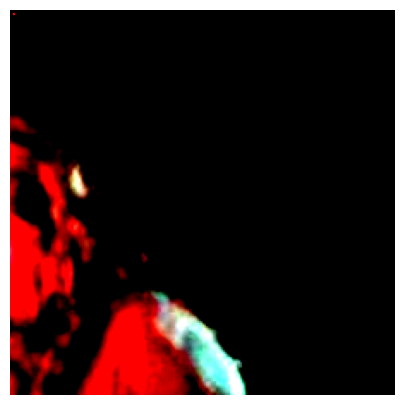

In [ ]:
# Load file model
face_detector.load_state_dict(torch.load("face_detector.pth"))

# test a random image
image, (res, target) = dataset_test[rd.randint(0, len(dataset_test) - 1)]
image = image.unsqueeze(0)
output = face_detector(image)
output_class, output_bbox = output

# show the image with the predicted bbox
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image.squeeze().permute(1, 2, 0))
x, y, w, h = output_bbox.squeeze().detach().numpy()
rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
ax.add_patch(rect)
ax.axis('off')



